# plot simulated peaks g15

In [1]:
import pycuda.gpuarray as gpuarray
from pycuda.autoinit import context
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
dev=cuda.Device(2)
dev.make_context()

import util.RotRep as Rot

In [58]:
import numpy as np
x15=np.load('/home/yufengs/Results/g15_2nd/x.npy')
y15=np.load('/home/yufengs/Results/g15_2nd/y.npy')
S15=np.load('/home/yufengs/Results/g15_2nd/allMaxS.npy')

In [4]:
Im=[]
for ii in range(96):
    Im.append(np.load('/home/yufengs/workspace/g15Ps1_2nd_filtered/Im{0:d}.npy'.format(ii)))
Lim=[]
for ii in range(96):
    Lim.append(np.load('/home/yufengs/workspace/g15Ps1_2nd_bf/limit{0:d}.npy'.format(ii)))

In [5]:
from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('ConfigFiles/g15Ps1_2nd.yml')
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        bfPath=Cfg.bfPath,
        fltPath=Cfg.fltPath,
        maxIntfn=Cfg.maxIntfn,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()

In [6]:
NumD=len(x15)

S15D=gpuarray.to_gpu(S15.ravel().astype(np.float32))

XD=gpuarray.empty(96*NumD,dtype=np.int32)
YD=gpuarray.empty(96*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(96*NumD,dtype=np.int32)

MaskD=gpuarray.empty(96*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(96*NumD,dtype=np.bool_)

x15D=gpuarray.to_gpu(x15.astype(np.float32))
y15D=gpuarray.to_gpu(y15.astype(np.float32))

In [7]:
recon.loadIm()

In [30]:
Range=np.array([2,5,0.01,1,1,1])**2 #dK pixel; dJ pixel; dD mm; dT degree
totalTry=1000
cutTry=50
MaxIter=100
mean=np.zeros(6)
cov=np.diag(Range)

for jj in range(MaxIter):
    tmp=np.random.multivariate_normal(
        mean,cov,size=totalTry)

    tmpres=[]
    for ii in range(len(tmp)):
        t=tmp[ii]
        T=Rot.EulerZXZ2Mat(t[3:6]/180.0*np.pi)
        tmpres.append(totalScore(t[0],t[1],t[2],T))
    print(np.max(tmpres))
    args=np.argpartition(tmpres,-cutTry)[-cutTry:]
    cov=np.cov(tmp[args].T)
    mean=np.mean(tmp[args],axis=0)
    if np.max(tmpres)==np.min(tmpres):
        print('Max equals Min')
        break
    if np.trace(np.absolute(cov))<1e-9:
        print('Cov is small')
        break
print(mean)
print(cov)

108589.39
113280.88
113931.27
114373.96
114603.44
114819.08
114928.59
114948.08
114948.83
114949.04
114949.13
114949.234
114949.21
114949.22
114949.22
114949.22
114949.23
114949.22
114949.22
114949.22
114949.22
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
114949.234
Max equals Min
[ 9.11207002e-03  3.78028844e-04  4.78056788e-06  1.09459140e+00
 -2.32998480e-05 -1.09448089e+00]
[[ 4.58193833e-10 -4.68283181e-11  1.60143114e-13 -1.46120923e-06
  -1.33956114e-14  1.46121406e-06]
 [-4.68283181e-11  7.115

In [13]:
def totalScore(dJ=0,dK=0,dD=0,dT=np.eye(3)):
    recon.ResetDet()
    #recon.MoveDet(dT=Rot.EulerZXZ2Mat(np.array([0,1,-0.5])/180.0*np.pi))
    recon.MoveDet(dJ,dK,dD,dT)
    BlockSize=256
    scoreD=gpuarray.empty(NumD,dtype=np.float32)
    recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                        x15D, y15D,recon.afDetInfoD,S15D,
                        recon.whichOmegaD,np.int32(NumD),np.int32(96),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                         block=(recon.NumG,1,1),grid=(NumD,1))
    recon.hit_func(scoreD,
                    XD,YD,OffsetD,MaskD,TrueMaskD,
                    recon.MaxIntD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                    block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
    scoreH=scoreD.get()
#     print(np.sum(scoreH))
    recon.ResetDet()
    return np.sum(scoreH)

In [20]:
print(totalScore(0,0,0,np.eye(3)))

114948.47


In [32]:
def totalSim(dJ=0,dK=0,dD=0,dT=np.eye(3)):
    recon.ResetDet()
    recon.MoveDet(dJ,dK,dD,dT)
    BlockSize=256
    scoreD=gpuarray.empty(NumD,dtype=np.float32)
    recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                        x15D, y15D,recon.afDetInfoD,S15D,
                        recon.whichOmegaD,np.int32(NumD),np.int32(96),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                         block=(recon.NumG,1,1),grid=(NumD,1))
    recon.hit_func(scoreD,
                    XD,YD,OffsetD,MaskD,TrueMaskD,
                    recon.MaxIntD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                    block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
    scoreH=scoreD.get()
    recon.ResetDet()
    
    XH=XD.get()
    YH=YD.get()
    OH=OffsetD.get()
    xtmp=XH.reshape((-1,96))
    ytmp=YH.reshape((-1,96))
    otmp=OH.reshape((-1,96))

    return scoreH,xtmp,ytmp,otmp

In [40]:
XH=XD.get()
YH=YD.get()
OH=OffsetD.get()
MH=MaskD.get()
TMH=TrueMaskD.get()

xtmp=XH.reshape((-1,96))
ytmp=YH.reshape((-1,96))

otmp=OH.reshape((-1,96))

In [33]:
scoreH,xtmp,ytmp,otmp=totalSim()

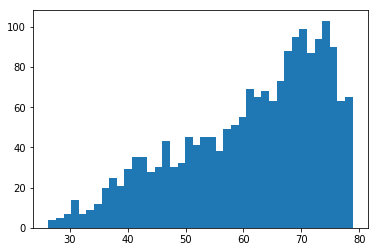

In [35]:
plt.hist(scoreH,bins=40)
plt.show()

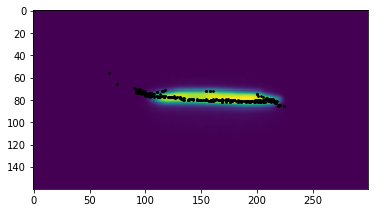

In [44]:
import matplotlib.pyplot as plt
ii=56

# idx=np.arange(len(xtmp))
idx=np.where(scoreH<50)

plt.imshow(np.sum(Im[ii][min(otmp[:,ii]):max(otmp[:,ii])+1],axis=0))
plt.scatter(xtmp[idx,ii],ytmp[idx,ii],s=3,c='k')
plt.show()

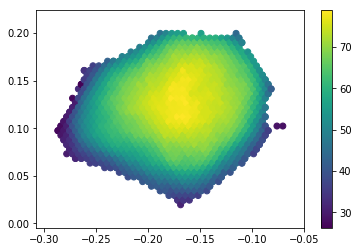

In [59]:
plt.scatter(x15,y15,c=scoreH)
plt.colorbar()
# plt.scatter(x15[idx],y15[idx],c='k')

plt.show()

# plot simulated peaks g13

In [11]:
import numpy as np
x13=np.load('/home/yufengs/Results/g13_2nd/x.npy')
y13=np.load('/home/yufengs/Results/g13_2nd/y.npy')
S13=np.load('/home/yufengs/Results/g13_2nd/allMaxS.npy')

Im=[]
for ii in range(108):
    Im.append(np.load('/home/yufengs/workspace/g13Ps1_2nd_filtered/Im{0:d}.npy'.format(ii)))
Lim=[]
for ii in range(108):
    Lim.append(np.load('/home/yufengs/workspace/g13Ps1_2nd_bf/limit{0:d}.npy'.format(ii)))

from InitStrain import Initializer
from Reconst_GPU import StrainReconstructor_GPU
Cfg=Initializer('ConfigFiles/g13Ps1_2nd.yml')
Cfg.Simulate()
recon=StrainReconstructor_GPU( _NumG=Cfg.NumG,
        bfPath=Cfg.bfPath,
        fltPath=Cfg.fltPath,
        maxIntfn=Cfg.maxIntfn,
        _Det=Cfg.Det, _Gs=Cfg.Gs, _Info=Cfg.Info, _eng=Cfg.eng)
recon.loadGs()

NumD=len(x13)

S13D=gpuarray.to_gpu(S13.ravel().astype(np.float32))

XD=gpuarray.empty(108*NumD,dtype=np.int32)
YD=gpuarray.empty(108*NumD,dtype=np.int32)
OffsetD=gpuarray.empty(108*NumD,dtype=np.int32)

MaskD=gpuarray.empty(108*NumD,dtype=np.bool_)
TrueMaskD=gpuarray.empty(108*NumD,dtype=np.bool_)

x13D=gpuarray.to_gpu(x13.astype(np.float32))
y13D=gpuarray.to_gpu(y13.astype(np.float32))

recon.loadIm()

In [4]:
def totalSim(dJ=0,dK=0,dD=0,dT=np.eye(3)):
    recon.ResetDet()
    recon.MoveDet(dJ,dK,dD,dT)
    BlockSize=256
    scoreD=gpuarray.empty(NumD,dtype=np.float32)
    recon.sim_grain(XD,YD,OffsetD,MaskD,TrueMaskD,
                        x13D, y13D,recon.afDetInfoD,S13D,
                        recon.whichOmegaD,np.int32(NumD),np.int32(108),np.float32(recon.eng),np.int32(45),recon.LimD,np.int32(5),
                         block=(recon.NumG,1,1),grid=(NumD,1))
    recon.hit_func(scoreD,
                    XD,YD,OffsetD,MaskD,TrueMaskD,
                    recon.MaxIntD,np.int32(recon.NumG),np.int32(NumD),np.int32(45),
                    block=(BlockSize,1,1),grid=(int(NumD/BlockSize+1),1))
    scoreH=scoreD.get()
    recon.ResetDet()
    
    XH=XD.get()
    YH=YD.get()
    OH=OffsetD.get()
    xtmp=XH.reshape((-1,108))
    ytmp=YH.reshape((-1,108))
    otmp=OH.reshape((-1,108))

    return scoreH,xtmp,ytmp,otmp

In [12]:
scoreH,xtmp,ytmp,otmp=totalSim()

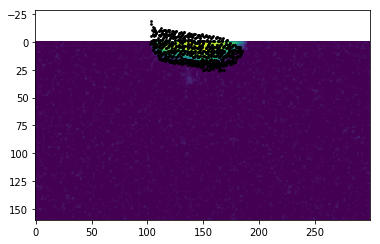

In [23]:
import matplotlib.pyplot as plt
ii=9

# idx=np.arange(len(xtmp))
idx=np.where(scoreH>40)

plt.imshow(np.sum(Im[ii][min(otmp[:,ii]):max(otmp[:,ii])+1],axis=0))
plt.scatter(xtmp[idx,ii],ytmp[idx,ii],s=3,c='k')

plt.show()

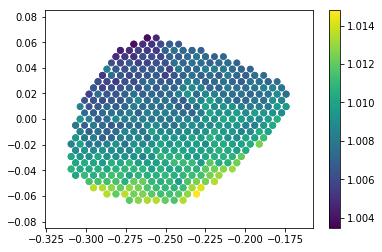

In [5]:
import numpy as np
import matplotlib.pyplot as plt
x13=np.load('/home/yufengs/Results/g13_2nd_bak/x.npy')
y13=np.load('/home/yufengs/Results/g13_2nd_bak/y.npy')
S13=np.load('/home/yufengs/Results/g13_2nd_bak/allMaxS.npy')
c13=np.load('/home/yufengs/Results/g13_2nd_bak/allMaxScore.npy')

idx=c13>50
plt.scatter(x13[idx],y13[idx],c=S13[idx,0,0])
plt.colorbar()

plt.show()

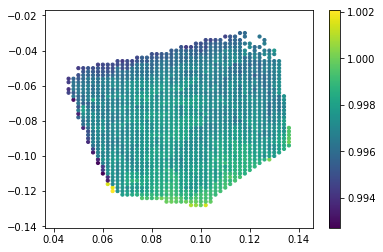

In [18]:
import numpy as np
import matplotlib.pyplot as plt
x23=np.load('/home/yufengs/SimData/g23/x.npy')
y23=np.load('/home/yufengs/SimData/g23/y.npy')
S23=np.load('/home/yufengs/SimData/g23/allMaxS.npy')
c23=np.load('/home/yufengs/SimData/g23/allMaxScore.npy')

idx=c23>50
plt.scatter(x23[idx],y23[idx],c=S23[idx,1,1],s=10)
plt.colorbar()

plt.show()

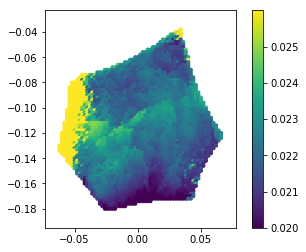

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x40=np.load('/home/yufengs/SimData/g40_fac40/x.npy')
y40=np.load('/home/yufengs/SimData/g40_fac40/y.npy')
S40=np.load('/home/yufengs/SimData/g40_fac40/allMaxS.npy')
c40=np.load('/home/yufengs/SimData/g40_fac40/allMaxScore.npy')

idx=c40>0
plt.scatter(x40[idx],-y40[idx],c=S40[idx,2,2]-1,s=10
            ,vmin=0.02,vmax=0.026
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

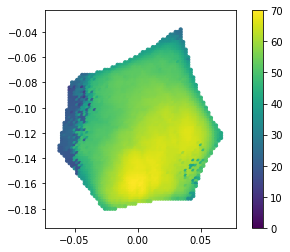

In [14]:
idx=c40>0
plt.scatter(x40[idx],-y40[idx],c=c40[idx],s=10
            ,vmin=0,vmax=70
           )
plt.axis('scaled')
plt.colorbar()

plt.show()

In [12]:
S40.shape

(3028, 3, 3)